In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import date
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
judges = pd.read_csv("/kaggle/input/indian-law-stats/judges_clean/judges_clean.csv")
merge_key = pd.read_csv("/kaggle/input/indian-law-stats/keys/keys/judge_case_merge_key.csv")

In [3]:
disp_keys = pd.read_csv("/kaggle/input/indian-law-stats/keys/keys/disp_name_key.csv")

In [4]:
criminal_cases = pd.read_csv("/kaggle/input/casestypes/Archive 2/ipc_cases_2016-18.csv")

We analyse the differences in the dispositions given out by male and female judges for different criminal cases under the ipc and check if there are any gender biases that the judge may have regarding the defendent and the advocate.

We sample cases from 2016 to 2018 for this analysis

## Acts Involved
- Criminal Cases under IPC

## Analysis

We analyse the following statements and see if they hold true:
- Are male judges more likey to handle criminal cases?
- is the average term served by judges the same for men and women?
- Is gender of judge a factor when a judge gives a disposition in a case.
- Can the gender of the defendent or advocate influece the disposition

## Average Term Served in District Court


First, let us look at the average term served for both genders, and see if there is any discrimination in the results for male and female judges

To clean up the data, we first drop null values, then trim the data so that we don't have inaccurate data

In [5]:
judges_served = judges.dropna(subset=["end_date"]).copy()
judges_served["Serving Period"] = pd.to_datetime(judges_served["end_date"]) - pd.to_datetime(judges_served["start_date"])

In [6]:
judges_served["start_date"] = pd.to_datetime(judges_served["start_date"])
judges_served["end_date"] = pd.to_datetime(judges_served["end_date"])
judges_served = judges_served[(judges_served.start_date > pd.to_datetime("2010-01-01")) & (judges_served.end_date > judges_served.start_date)]

In [7]:
judges_served = judges_served[judges_served.female_judge.isin(["-9998 unclear"]) == False]
judges_served[['female_judge',"Serving Period"]].groupby(by="female_judge").mean()

,Serving Period
female_judge,
0 nonfemale,454 days 01:00:15.093380768
1 female,434 days 06:48:21.563271352


As we see from the above table, female judges have a lesser tenure, but not by a lot. So it is safe to say that female judges stay in district courts almost just as long as their male counterparts.

Now, we move on to analysing gender bias in judging cases.

# Gender Bias in Judging Cases

In [8]:
total_case_counts = 0

<AxesSubplot:title={'center':'Criminal Cases'}, ylabel='Number of Cases'>

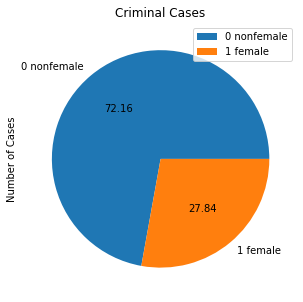

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

case = criminal_cases
case_judges_df = pd.merge(pd.merge(case[["ddl_case_id","disp_name","year"]], merge_key[["ddl_case_id","ddl_decision_judge_id"]], on="ddl_case_id"), judges[["ddl_judge_id","female_judge"]], left_on="ddl_decision_judge_id", right_on="ddl_judge_id").drop("ddl_judge_id", axis="columns")
case_judges_df = pd.merge(case_judges_df, disp_keys[["year","disp_name","disp_name_s"]], left_on=["disp_name", "year"], right_on=["disp_name","year"])
case_judges_df = case_judges_df[case_judges_df.female_judge.isin(["-9998 unclear"]) == False]
df_to_draw = case_judges_df[["ddl_case_id","female_judge"]].groupby(by="female_judge").count()
total_case_counts = df_to_draw["ddl_case_id"].values
df_to_draw.plot.pie(y = "ddl_case_id", ylabel="Number of Cases", title = "Criminal Cases", ax=ax, autopct="%.2f")



As we can see from the top left plot, in our selected time period, a male judge is about 2 times as likely to make a decision on a criminal case under IPC than a woman. This reaffirms the gender gap that still exists in the profession of being a judge.

# Disposition Analysis

Now, we focus our attention to certain specific dispositions given by judges for all the types of cases listed above.
The dispositions we will focus on are: 
- convicted
- acquitted
- bail granted
- bail rejected
- execution
- probation

We will analyse the dispositions based on 3 factors:
1. Gender of Judge
2. Gender of Defendent
3. Gender of Defendent Advocate

In [10]:
disp_key_codes = [20, 4, 8, 11, 29, 40]
disp_titles = ["Convicted", "Acquitted", "Bail Granted", "Bail Rejected", "Execution", "Probation"]

## 1.  Gender of Judge

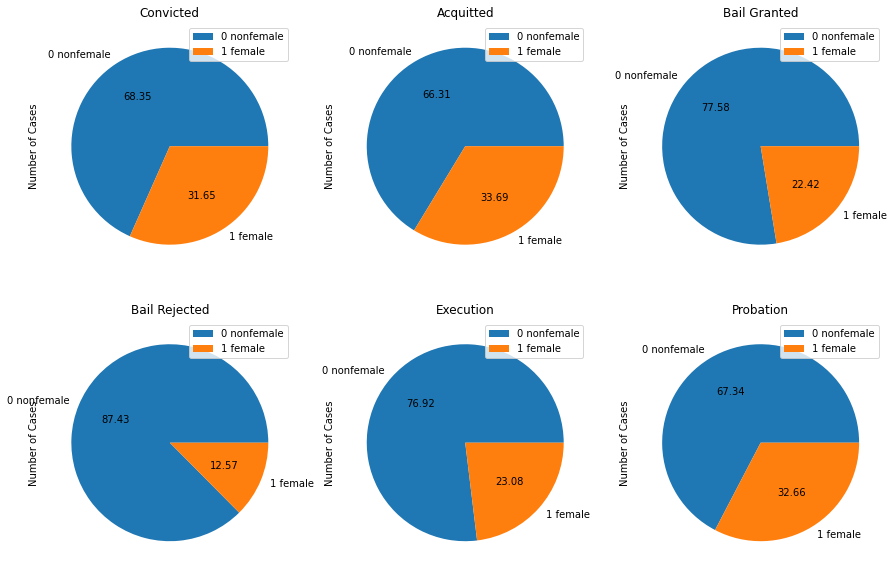

In [11]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

case_temp = criminal_cases

c1 = 0
c2 = 0
for i, disp in enumerate(disp_key_codes):
    case = case_temp[case_temp.disp_name == disp]
    case_judges_df = pd.merge(pd.merge(case[["ddl_case_id","year"]], merge_key[["ddl_case_id","ddl_decision_judge_id"]], on="ddl_case_id"), judges[["ddl_judge_id","female_judge"]], left_on="ddl_decision_judge_id", right_on="ddl_judge_id").drop("ddl_judge_id", axis="columns")
#     case_judges_df = pd.merge(case_judges_df, disp_keys[["year","disp_name","disp_name_s"]], left_on=["disp_name", "year"], right_on=["disp_name","year"])
    case_judges_df = case_judges_df[case_judges_df.female_judge.isin(["-9998 unclear"]) == False]
    df_to_draw = case_judges_df[["ddl_case_id","female_judge"]].groupby(by="female_judge").count()
    df_to_draw.plot.pie(y = "ddl_case_id", ylabel="Number of Cases", title = disp_titles[i], ax=ax[c1][c2], autopct="%.2f")
    if(i % 3 == 2):
        c1+=1
        c2=0
    else:
        c2+=1

When we look at raw numbers without normalisation, we see that in criminal cases, convictions and acquittals are decided by male judges about 67% of the time, which is consistant with the fact that male judges handle around 70% of the cases.

Looking at bail stats, we see that male judges grant bail almost 4 times as frequently as a female judge, and they reject bail around 8 times as frequently.

Now, let us take a look at normalised values

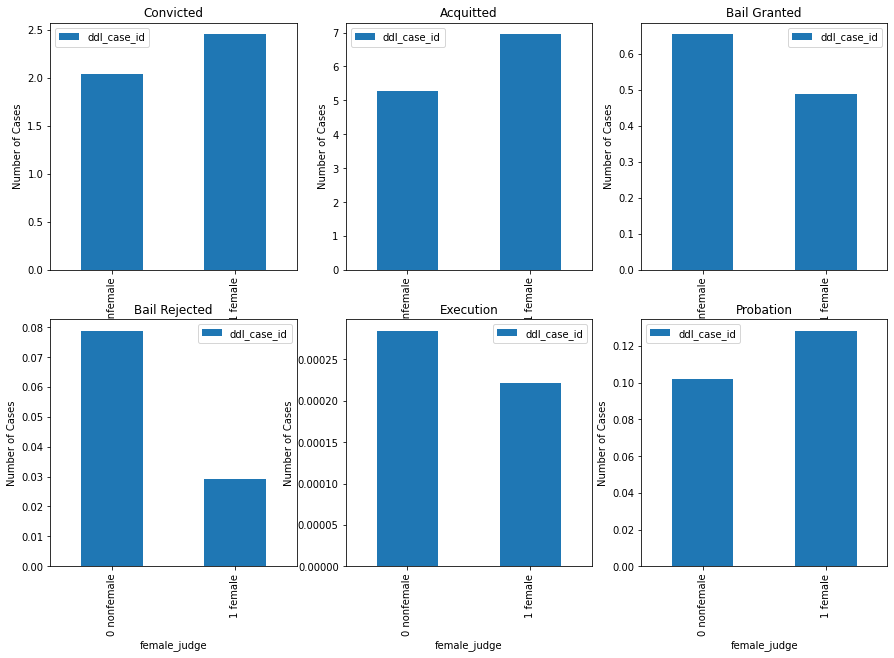

In [12]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

case_temp = criminal_cases

c1 = 0
c2 = 0
for i, disp in enumerate(disp_key_codes):
    case = case_temp[case_temp.disp_name == disp]
    case_judges_df = pd.merge(pd.merge(case[["ddl_case_id","year"]], merge_key[["ddl_case_id","ddl_decision_judge_id"]], on="ddl_case_id"), judges[["ddl_judge_id","female_judge"]], left_on="ddl_decision_judge_id", right_on="ddl_judge_id").drop("ddl_judge_id", axis="columns")
#     case_judges_df = pd.merge(case_judges_df, disp_keys[["year","disp_name","disp_name_s"]], left_on=["disp_name", "year"], right_on=["disp_name","year"])
    case_judges_df = case_judges_df[case_judges_df.female_judge.isin(["-9998 unclear"]) == False]
    df_to_draw = case_judges_df[["ddl_case_id","female_judge"]].groupby(by="female_judge").count()
    df_to_draw["ddl_case_id"].iloc[0] = 100*df_to_draw["ddl_case_id"].iloc[0]/total_case_counts[0]
    df_to_draw["ddl_case_id"].iloc[1] = 100*df_to_draw["ddl_case_id"].iloc[1]/total_case_counts[1]
    df_to_draw.plot.bar(y = "ddl_case_id", ylabel="Number of Cases", title = disp_titles[i], ax=ax[c1][c2])
    if(i % 3 == 2):
        c1+=1
        c2=0
    else:
        c2+=1

From the above graphs, we can infer that actually, a female judge is more likely to order a conviction. A female judge ordered a conviction 2.5% of the times, while a male judge ordered a conviction 2% of the times.

Another insight we gain is that while male judges give out acquittals, once again a female judge is more likey to grant acquittals as opposed to their male counterparts: with 7% and 5% of cases being acquitted respectively.

However, female judges do not deal with bail related orders. As the bottom two graphs show, male judges are more likey to both grant and reject a bail.

# 2. Gender of Defendent

<AxesSubplot:title={'center':'Probation'}, ylabel='Number of Cases'>

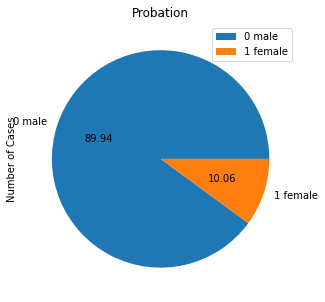

In [13]:
total_case_counts_2 = []
fig, ax = plt.subplots(figsize=(5,5))

case_temp = criminal_cases

case = case_temp
case_judges_df = case[["ddl_case_id","year","female_defendant"]]
#     case_judges_df = pd.merge(case_judges_df, disp_keys[["year","disp_name","disp_name_s"]], left_on=["disp_name", "year"], right_on=["disp_name","year"])
case_judges_df = case_judges_df[case_judges_df.female_defendant.isin(["0 male", "1 female"]) == True]
df_to_draw = case_judges_df[["ddl_case_id","female_defendant"]].groupby(by="female_defendant").count()
total_case_counts_2 = df_to_draw["ddl_case_id"].values
df_to_draw.plot.pie(y = "ddl_case_id", ylabel="Number of Cases", title = disp_titles[i], ax=ax, autopct="%.2f")

The figure above shows the share of cases having male defendants vs those having female defendamts. As we can see, male defendants make up about 90% of the cases. Now, let us dive into the specifics.

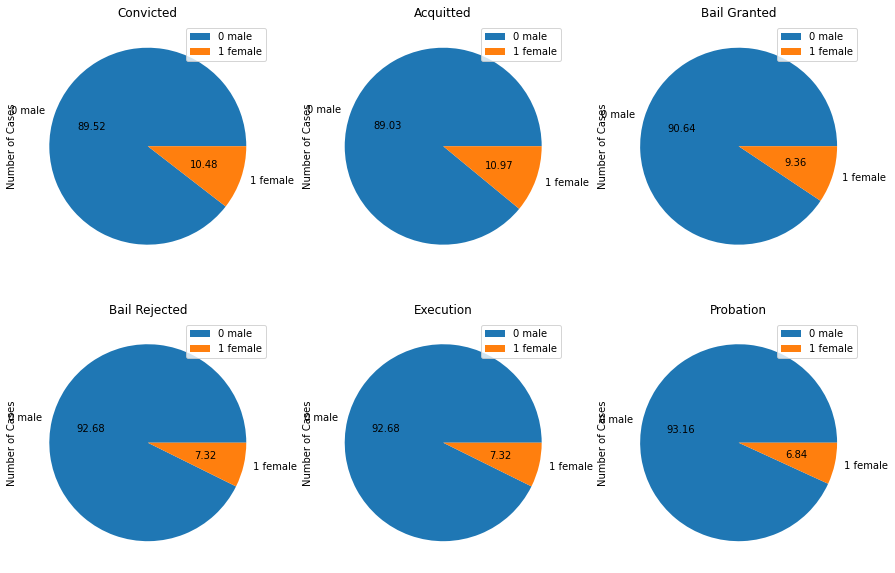

In [14]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

case_temp = criminal_cases

c1 = 0
c2 = 0
for i, disp in enumerate(disp_key_codes):
    case = case_temp[case_temp.disp_name == disp]
    case_judges_df = case[["ddl_case_id","year","female_defendant"]]
#     case_judges_df = pd.merge(case_judges_df, disp_keys[["year","disp_name","disp_name_s"]], left_on=["disp_name", "year"], right_on=["disp_name","year"])
    case_judges_df = case_judges_df[case_judges_df.female_defendant.isin(["0 male", "1 female"]) == True]
    df_to_draw = case_judges_df[["ddl_case_id","female_defendant"]].groupby(by="female_defendant").count()
    df_to_draw.plot.pie(y = "ddl_case_id", ylabel="Number of Cases", title = disp_titles[i], ax=ax[c1][c2], autopct="%.2f")
    if(i % 3 == 2):
        c1+=1
        c2=0
    else:
        c2+=1

With male defendants making up 94% of the cases, it is no surprise that in total counts of dispositions, male defendants are the ones being given those dispositions most of the times.

To clear out this bais, we look at normalised data.

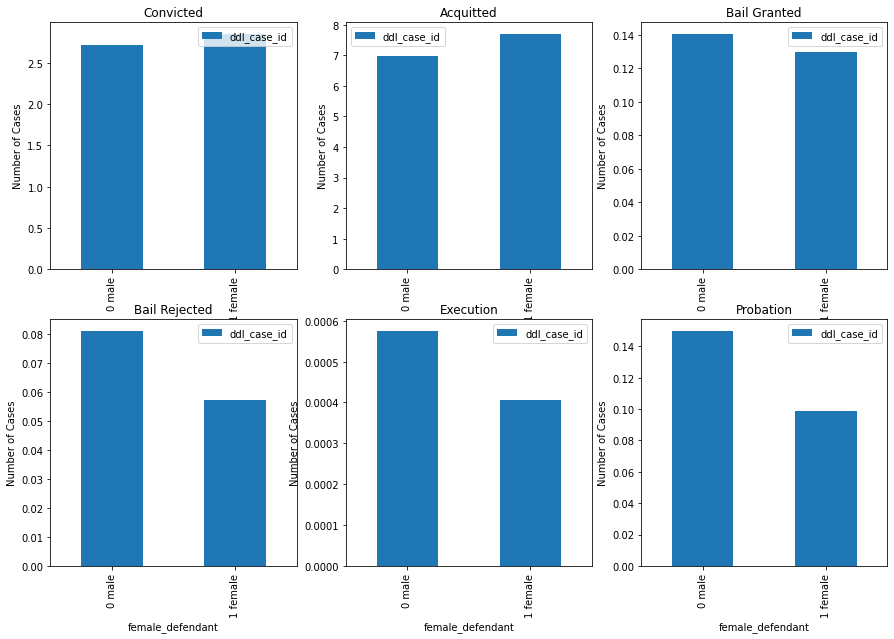

In [15]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

case_temp = criminal_cases

c1 = 0
c2 = 0
for i, disp in enumerate(disp_key_codes):
    case = case_temp[case_temp.disp_name == disp]
    case_judges_df = case[["ddl_case_id","year","female_defendant"]]
#     case_judges_df = pd.merge(case_judges_df, disp_keys[["year","disp_name","disp_name_s"]], left_on=["disp_name", "year"], right_on=["disp_name","year"])
    case_judges_df = case_judges_df[case_judges_df.female_defendant.isin(["0 male", "1 female"]) == True]
    df_to_draw = case_judges_df[["ddl_case_id","female_defendant"]].groupby(by="female_defendant").count()
    df_to_draw["ddl_case_id"].iloc[0] = 100*df_to_draw["ddl_case_id"].iloc[0]/total_case_counts_2[0]
    df_to_draw["ddl_case_id"].iloc[1] = 100*df_to_draw["ddl_case_id"].iloc[1]/total_case_counts_2[1]
    df_to_draw.plot.bar(y = "ddl_case_id", ylabel="Number of Cases", title = disp_titles[i], ax=ax[c1][c2])
    if(i % 3 == 2):
        c1+=1
        c2=0
    else:
        c2+=1

On normalising the data by dividing by the total number of cases for men and women defendants respectivey, the findings are a little more balanced. We can see that a woman defendant is slightly more likey to get acquitted, and less likey to get a bail rejected. Also, men are more likey to be executed and also more likely to be given a probation


# 3. Gender of Advocate

<AxesSubplot:title={'center':'Probation'}, ylabel='Number of Cases'>

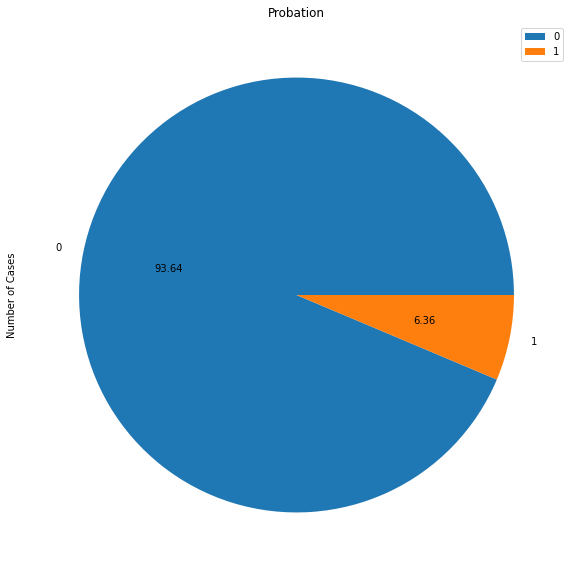

In [16]:
total_case_counts_3 = []
fig, ax = plt.subplots(figsize=(15,10))

case_temp = criminal_cases

case = case_temp
case_judges_df = case[["ddl_case_id","year","female_adv_def"]]
#     case_judges_df = pd.merge(case_judges_df, disp_keys[["year","disp_name","disp_name_s"]], left_on=["disp_name", "year"], right_on=["disp_name","year"])
case_judges_df = case_judges_df[case_judges_df.female_adv_def.isin([0, 1]) == True]
df_to_draw = case_judges_df[["ddl_case_id","female_adv_def"]].groupby(by="female_adv_def").count()
total_case_counts_3 =df_to_draw["ddl_case_id"].values
df_to_draw.plot.pie(y = "ddl_case_id", ylabel="Number of Cases", title = disp_titles[i], ax=ax, autopct="%.2f")

The gender gap for lawyers and advocates is even larger, with just 6% of the lawyers in this subset of data being female

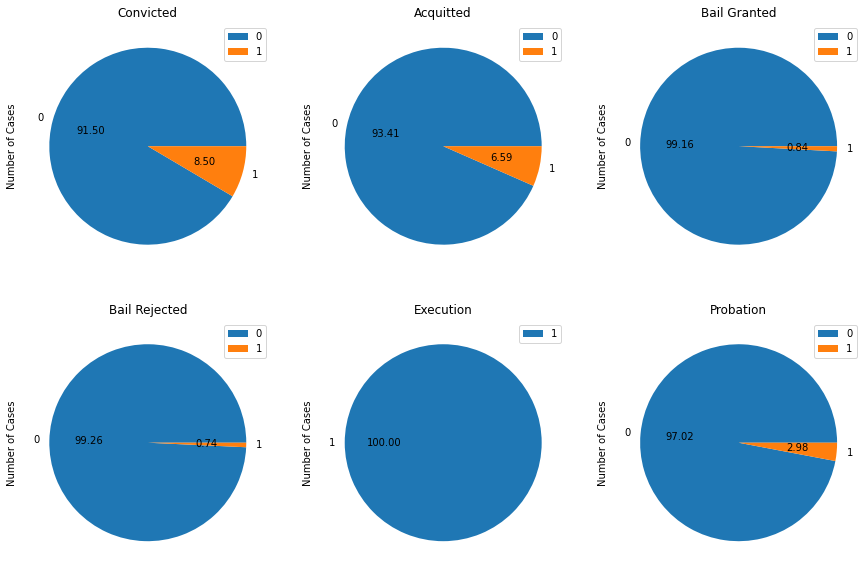

In [17]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

case_temp = criminal_cases

c1 = 0
c2 = 0
for i, disp in enumerate(disp_key_codes):
    case = case_temp[case_temp.disp_name == disp]
    case_judges_df = case[["ddl_case_id","year","female_adv_def"]]
#     case_judges_df = pd.merge(case_judges_df, disp_keys[["year","disp_name","disp_name_s"]], left_on=["disp_name", "year"], right_on=["disp_name","year"])
    case_judges_df = case_judges_df[case_judges_df.female_adv_def.isin([0, 1]) == True]
    df_to_draw = case_judges_df[["ddl_case_id","female_adv_def"]].groupby(by="female_adv_def").count()
    df_to_draw.plot.pie(y = "ddl_case_id", ylabel="Number of Cases", title = disp_titles[i], ax=ax[c1][c2], autopct="%.2f")
    if(i % 3 == 2):
        c1+=1
        c2=0
    else:
        c2+=1

As is expected from the overall landslide majority of male lawyers, they whitewash women in every category when looking at raw numbers. Thus, we now move to normalised data

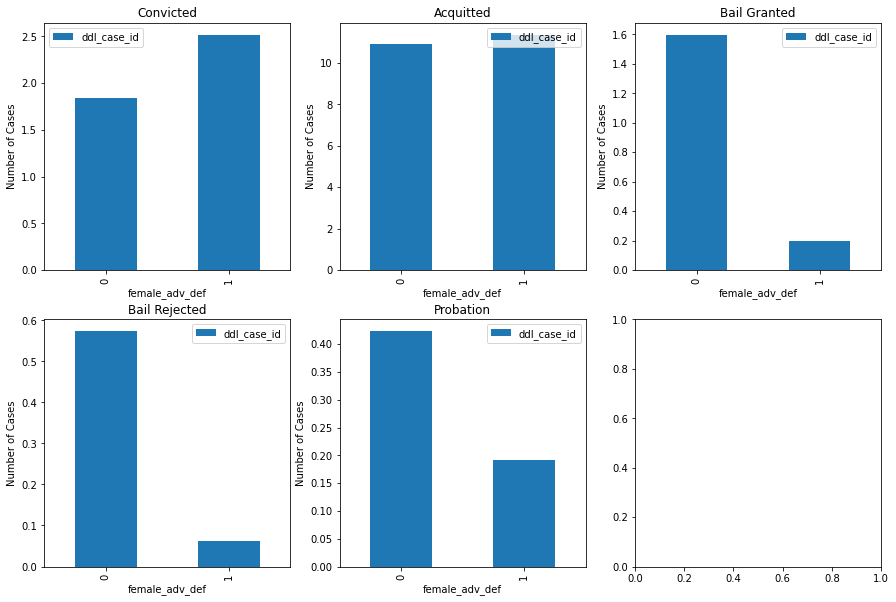

In [18]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

case_temp = criminal_cases

c1 = 0
c2 = 0
for i, disp in enumerate(disp_key_codes):
    if(i == 4): continue
    case = case_temp[case_temp.disp_name == disp]
    case_judges_df = case[["ddl_case_id","year","female_adv_def"]]
#     case_judges_df = pd.merge(case_judges_df, disp_keys[["year","disp_name","disp_name_s"]], left_on=["disp_name", "year"], right_on=["disp_name","year"])
    case_judges_df = case_judges_df[case_judges_df.female_adv_def.isin([0, 1]) == True]
    df_to_draw = case_judges_df[["ddl_case_id","female_adv_def"]].groupby(by="female_adv_def").count()
    df_to_draw["ddl_case_id"].iloc[0] = 100*df_to_draw["ddl_case_id"].iloc[0]/total_case_counts_3[0]
    if(df_to_draw["ddl_case_id"].iloc[1] != None):
        df_to_draw["ddl_case_id"].iloc[1] = 100*df_to_draw["ddl_case_id"].iloc[1]/total_case_counts_3[1]
    df_to_draw.plot.bar(y = "ddl_case_id", ylabel="Number of Cases", title = disp_titles[i], ax=ax[c1][c2])
    if(i % 3 == 2):
        c1+=1
        c2=0
    else:
        c2+=1

From these graphs, we can see that a defendant is more likely to be convicted if they hire a female laywer. Also, the chance of getting a bail granted is higher with a mail advocate, but conversly, getting a bail rejected is also more likely if one has a male lawyer.
Lastly, male lawyers enjoy a higher percentage of thier cases ending in probation

# Conclusion
We conclude that the gender of the judge does not have a significant influce on the disposition of the case. The trends over different dispositions were more or less balanced.

For defendants, gender does matter in getting a disposition, as was elaborated above.

For lawyers, we find a vast gender gap in this profession between men and women, and also found that one is statistically more likely to get convicted if they employ a female lawyer.

Thus, with these findings we can say that gender does indeed factor in a little in terms of the outcomes of a case